In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__)); Pkg.instantiate();
using BilinearControl
using BilinearControl.Problems
using BilinearControl.EDMD
import RobotDynamics as RD
import TrajectoryOptimization as TO
using LinearAlgebra
using RobotZoo
using JLD2
using SparseArrays
using Plots
using Distributions
using Distributions: Normal
using Random
using FiniteDiff, ForwardDiff
using Test
using Altro
using QDLDL
using BilinearControl: Problems

  Activating project at `~/.julia/dev/BilinearControl/examples`


In [2]:
Threads.nthreads()

10

In [3]:
include("learned_models/edmd_utils.jl");

In [4]:
## Visualizer
model = Cartpole2()
include(joinpath(Problems.VISDIR, "visualization.jl"))
vis = Visualizer()
delete!(vis)
set_cartpole!(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/jeonghun/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat Visualizer with path /meshcat/robot/cart/pole at http://127.0.0.1:8700

In [5]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8700))

# Define Cartpole Model

In [6]:
model = Cartpole2()  # this model has damping
dmodel = RD.DiscretizedDynamics{RD.RK4}(model)
tf = 2.0
dt = 0.02;

# Generate Training/Test Data

### Generate LQR Stabilizing Training/Test Trajectories


In [7]:
Random.seed!(1)

# number of trajectories
num_train = 30
num_test = 10

# Generate a stabilizing LQR controller about the top
Qlqr = Diagonal([0.2,10,1e-2,1e-2])
Rlqr = Diagonal([1e-3])
xe = [0,pi,0,0]
ue = [0.0]
ctrl_lqr = LQRController(dmodel, Qlqr, Rlqr, xe, ue, dt)

# Sample a bunch of initial conditions for the LQR controller
x0_sampler = Product([
    Uniform(-1.0,1.0),
    Uniform(pi-pi/3,pi+pi/3),
    Uniform(-.5,.5),
    Uniform(-.5,.5),
])
initial_conditions_lqr = [rand(x0_sampler) for _ in 1:num_train]
initial_conditions_test = [rand(x0_sampler) for _ in 1:num_test]

# Create data set
X_train_lqr, U_train_lqr = create_data(dmodel, ctrl_lqr, initial_conditions_lqr, tf, dt)
X_test_lqr, U_test_lqr = create_data(dmodel, ctrl_lqr, initial_conditions_test, tf, dt);

### Generate ALTRO Swing-up Training/Test Trajectories


In [8]:
function gencartpoleproblem(x0=zeros(4), Qv=1e-2, Rv=1e-1, Qfv=1e2, u_bnd=3.0, tf=5.0; 
    dt=0.05, constrained=true)

    model = Cartpole2()
    dmodel = RD.DiscretizedDynamics{RD.RK4}(model) 
    n,m = RD.dims(model)
    N = round(Int, tf/dt) + 1

    Q = Qv*Diagonal(@SVector ones(n)) * dt
    Qf = Qfv*Diagonal(@SVector ones(n))
    R = Rv*Diagonal(@SVector ones(m)) * dt
    xf = @SVector [0, pi, 0, 0]
    obj = TO.LQRObjective(Q,R,Qf,xf,N)

    conSet = TO.ConstraintList(n,m,N)
    bnd = TO.BoundConstraint(n,m, u_min=-u_bnd, u_max=u_bnd)
    goal = TO.GoalConstraint(xf)
    if constrained
    TO.add_constraint!(conSet, bnd, 1:N-1)
    TO.add_constraint!(conSet, goal, N:N)
    end

    X0 = [@SVector fill(NaN,n) for k = 1:N]
    u0 = @SVector fill(0.01,m)
    U0 = [u0 for k = 1:N-1]
    Z = TO.SampledTrajectory(X0,U0,dt=dt*ones(N-1))
    prob = TO.Problem(dmodel, obj, x0, tf, constraints=conSet, xf=xf) 
    TO.initial_trajectory!(prob, Z)
    TO.rollout!(prob)
    prob
end;


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 507
    Solve Time: 521.771618 (ms)

  Covergence
    Terminal Cost: 26.19580265572744
    Terminal dJ: 0.0012142339048430983
    Terminal gradient: 0.00044822589938768175
    Terminal constraint violation: 6.650006945108089e-7
    Solve Status: SOLVE_SUCCEEDED
params = ([0.0, 0.0, 0.0, 0.0], 0.001, 0.01, 100.0, 5.0, 2.0)
params = ([0.0, 0.0, 0.0, 0.0], 0.001, 0.01, 100.0, 4.5, 2.0)
params = ([0.0, 0.0, 0.0, 0.0], 0.001, 1.0, 100.0, 5.0, 2.0)
params = ([0.0, 0.0, 0.0, 0.0], 0.001, 1.0, 100.0, 4.5, 2.0)
params = ([0.0, 0.0, 0.0, 0.0], 1.0, 0.01, 100.0, 5.0, 2.0)
params = ([0.0, 0.0, 0.0, 0.0], 1.0, 0.1, 100.0, 4.5, 2.0)


┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:18
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:49
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:49
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:49
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:49
┌ Warning: ALTRO Solve failed
└ @ Main In[9]:49
┌ Warning: ALTRO Solve failed
└ @ Main I

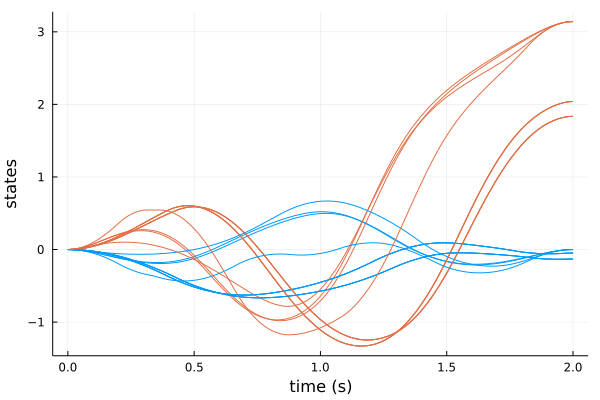

In [9]:
# number of trajectories
num_train = 15

# ALTRO Training
Random.seed!(1)
train_params = map(1:num_train) do i
    Qv = 1e-2
    Rv = Qv * 10^rand(Uniform(-1,3.0))
    Qfv = Qv * 10^rand(Uniform(1,5.0)) 
    u_bnd = rand(Uniform(4.5, 8.0))
    (zeros(4), Qv, Rv, Qfv, u_bnd, tf)
end

train_trajectories = map(train_params) do params
    solver = Altro.solve!(ALTROSolver(gencartpoleproblem(params..., dt=dt), 
        show_summary=false, projected_newton=true))
    if Altro.status(solver) != Altro.SOLVE_SUCCEEDED
        @warn "ALTRO Solve failed"
    end
    X = TO.states(solver)
    U = TO.controls(solver)
    Vector.(X), Vector.(U)
end
X_train_altro = mapreduce(x->getindex(x,1), hcat, train_trajectories)
U_train_altro = mapreduce(x->getindex(x,2), hcat, train_trajectories)

# ALTRO Test
test_params = [
    (zeros(4), 1e-3, 1e-2, 1e2, 10.0, tf),
    (zeros(4), 1e-3, 1e-2, 1e2, 5.0, tf),
    (zeros(4), 1e-3, 1e-2, 1e2, 4.5, tf),
    (zeros(4), 1e-3, 1e0, 1e2, 10.0, tf),
    (zeros(4), 1e-3, 1e-0, 1e2, 5.0, tf),
    (zeros(4), 1e-3, 1e-0, 1e2, 4.5, tf),
    (zeros(4), 1e-0, 1e-2, 1e2, 10.0, tf),
    (zeros(4), 1e-0, 1e-2, 1e2, 5.0, tf),
    (zeros(4), 1e-0, 1e-1, 1e2, 4.5, tf),
    (zeros(4), 1e-0, 1e-2, 1e-2, 10.0, tf),
]
prob = gencartpoleproblem(test_params[end]..., dt=dt)
solver = ALTROSolver(prob)
Altro.solve!(solver)
visualize!(vis, model, tf, TO.states(solver))

test_trajectories = map(test_params) do params
    solver = Altro.solve!(ALTROSolver(gencartpoleproblem(params...; dt), show_summary=false))
    if Altro.status(solver) != Altro.SOLVE_SUCCEEDED
        @show params
        @warn "ALTRO Solve failed"
    end
    X = TO.states(solver)
    U = TO.controls(solver)
    Vector.(X), Vector.(U)
end
X_test_altro = mapreduce(x->getindex(x,1), hcat, test_trajectories)
U_test_altro = mapreduce(x->getindex(x,2), hcat, test_trajectories)
time = range(0,tf,step=dt)

# Plot test trajectories
p = plot(ylabel="states", xlabel="time (s)")
for i = 1:size(X_test_altro,2)
    plot!(p, time, reduce(hcat, X_test_altro[:,i])[1:2,:]', label="", c=[1 2])
end
display(p)

In [10]:
X_train = [X_train_altro X_train_lqr]
U_train = [U_train_altro U_train_lqr];

In [11]:
#save data
jldsave(joinpath(Problems.DATADIR, "cartpole_trajectories.jld2"); 
    X_train=X_train, U_train=U_train, X_test_swing_up=X_test_altro, U_test_swing_up=U_test_altro, 
    X_test_stabilize=X_test_lqr, U_test_stabilize=U_test_lqr, tf, dt)

# Import Training/Test Data

In [12]:
# altro_traj = load(joinpath(Problems.DATADIR, "cartpole_altro_trajectories.jld2"))

# X_train = altro_traj["X_train"][:, 1:30]
# U_train = altro_traj["U_train"][:, 1:30]
# X_test_swing_up = altro_traj["X_test"][:, 1:10]
# U_test_swing_up = altro_traj["U_test"][:, 1:10]
# X_test_stabilize = altro_traj["X_lqr"][:, 1:10]
# U_test_stabilize = altro_traj["U_lqr"][:, 1:10]
# tf = altro_traj["tf"]
# dt = altro_traj["dt"]

# T_ref = range(0,tf,step=dt);

In [13]:
altro_lqr_traj = load(joinpath(Problems.DATADIR, "cartpole_trajectories.jld2"))

X_train = altro_lqr_traj["X_train"]
U_train = altro_lqr_traj["U_train"]
X_test_swing_up = altro_lqr_traj["X_test_swing_up"]
U_test_swing_up = altro_lqr_traj["U_test_swing_up"]
X_test_stabilize = altro_lqr_traj["X_test_stabilize"]
U_test_stabilize = altro_lqr_traj["U_test_stabilize"]
tf = altro_lqr_traj["tf"]
dt = altro_lqr_traj["dt"]

T_ref = range(0,tf,step=dt);

# Fit the Data using Nominal eDMD
This uses the standard eDMD model method used in the CalTech paper, which learns a model of the form:

$$ x^+ = A x + \sum_{i=1}^m u_i C_i x $$

In [14]:
# Define the basis functions
eigfuns = ["state", "sine", "cosine", "sine", "sine", "chebyshev"]
eigorders = [0,0,0,2,4,4];

In [15]:
# Fit the data
Z_train, Zu_train, kf = build_eigenfunctions(X_train, U_train, eigfuns, eigorders)

# A, B, C, g = learn_bilinear_model(X_train, Z_train, Zu_train,
#     ["ridge", "lasso"]; 
#     edmd_weights=[10.1], 
#     mapping_weights=[0.0], 
#     algorithm=:qr
# );

A, B, C, g = learn_bilinear_model(X_train, Z_train, Zu_train,
    ["na", "na"]; 
    edmd_weights=[0.0], 
    mapping_weights=[0.0], 
    algorithm=:qr
);

(T, K) = (148500, 2211)
issparse(X) = true
lambda = 0.0
(T, K) = (18000, 132)
issparse(X) = true
lambda = 0.0


In [16]:
# Save model
jldsave(joinpath(Problems.DATADIR,"cartpole_nominal_eDMD_data.jld2"); A, B, C, g, kf, eigfuns, eigorders, tf, dt)

# Import Nominal EDMD Model

In [17]:
cartpole_data = load(joinpath(Problems.DATADIR, "cartpole_nominal_eDMD_data.jld2"))
A_nom = cartpole_data["A"]
B_nom = cartpole_data["B"]
C_nom = cartpole_data["C"]
g_nom = cartpole_data["g"]
kf = cartpole_data["kf"]
tf = cartpole_data["tf"]
dt = cartpole_data["dt"];

# Evaluate the Nominal Fit
The fit is evaluated using:
$$ \frac{1}{P} \sum_{j=1}^P || g (A \varphi(x_j) + \sum_{i=1}^m u_{j,i} C_i \varphi(x_j)) - x_j^+ || $$

where $y = \varphi(x)$ is the Koopman transform.

In [18]:
err_train = BilinearControl.EDMD.fiterror(A_nom, B_nom, C_nom, g_nom, kf, X_train, U_train)
err_test_swing_up = BilinearControl.EDMD.fiterror(A_nom, B_nom, C_nom, g_nom, kf, X_test_swing_up, U_test_swing_up)
err_test_stabilize = BilinearControl.EDMD.fiterror(A_nom, B_nom, C_nom, g_nom, kf, X_test_stabilize, U_test_stabilize)
println("Train Error: ", err_train)
println("Swing-up Test Error:  ", err_test_swing_up)
println("Stabilization Test Error:  ", err_test_stabilize)

Train Error: 0.00970062565994878
Swing-up Test Error:  0.05276273389163401
Stabilization Test Error:  0.7188724443629827


### Define the Bilinear Model

In [19]:
model_bilinear = EDMDModel(A_nom,B_nom,C_nom,g_nom,kf,dt,"cartpole")
n,m = RD.dims(model_bilinear)
n0 = originalstatedim(model_bilinear)
println("New Hilbert state dimension: ", n)

New Hilbert state dimension: 33


### Compare Linearization
To see if the learned model captures the dynamics, we'll evaluate the effective `A` and `B` dynamics Jaocbians of the learned model on the original dynamics, and compare to the nominal Jacobians.

In [20]:
# Define the equilibrium
xe = [0.,pi,0,0]
ue = [0.0]
ze = RD.KnotPoint{n0,m}(xe,ue,0.0,dt)
ye = expandstate(model_bilinear, xe);

In [21]:
# Nominal Jacobians
J = zeros(n0,n0+m)
xn = zeros(n0)
RD.jacobian!(RD.InPlace(), RD.ForwardAD(), dmodel, J, xn, ze)
A_og = J[:,1:n0]
B_og = J[:,n0+1:end];

In [22]:
# Bilinear Jacobians
function dynamics_bilinear(x,u,t,dt)
    y = expandstate(model_bilinear, x)
    yn = zero(y)
    RD.discrete_dynamics!(model_bilinear, yn, y, u, t, dt)
    originalstate(model_bilinear, yn)
end

A_bil_nom = FiniteDiff.finite_difference_jacobian(x->dynamics_bilinear(x,ue,0.0,dt), xe)
B_bil_nom = FiniteDiff.finite_difference_jacobian(u->dynamics_bilinear(xe,u,0.0,dt), ue);

In [23]:
A_og

4×4 Matrix{Float64}:
 1.0  0.000392055   0.019998     -1.38375e-6
 0.0  1.0047       -3.99648e-6    0.0199834
 0.0  0.0392035     0.9998       -7.57316e-6
 0.0  0.470481     -0.000399628   0.999909

In [24]:
A_bil_nom

4×4 Matrix{Float64}:
  1.00004     0.000262927   0.0200253   -2.71075e-5
 -5.01275e-5  1.00455      -2.07126e-5   0.0199536
  0.00394925  0.02819       1.00243     -0.00232306
 -0.00347757  0.450083     -0.00126791   0.996073

In [25]:
B_og

4×1 Matrix{Float64}:
 0.00019995956333333334
 0.00039964806000000004
 0.01999523290316667
 0.03996279079433334

In [26]:
B_bil_nom

4×1 Matrix{Float64}:
 0.0001963500644421856
 0.0003992915153503418
 0.019686628467752598
 0.039884447382064536

# Try Stabilizing Nominal Model using LQR

In [27]:
# Calculate LQR Gain 
Qlqr = Diagonal([1.0,10.0,1e-2,1e-2])
Rlqr = Diagonal([1e-4])
K_og = dlqr(A_og, B_og, Qlqr, Rlqr)
K_bil_nom = dlqr(A_bil_nom, B_bil_nom, Qlqr, Rlqr);

In [28]:
# Evaluate stability
isstable_nominal = maximum(abs.(eigvals(A_og - B_og*K_og))) < 1.0
isstable_bilinear = maximum(abs.(eigvals(A_bil_nom - B_bil_nom*K_bil_nom))) < 1.0
isstable_nominal_with_bilinear = maximum(abs.(eigvals(A_og - B_og*K_bil_nom))) < 1.0

println("Stability Summary:")
println("  Dynamics  |  Controller  |  is stable? ")
println("------------|--------------|--------------")
println("  Nominal   |  Nominal     |  ", isstable_nominal)
println("  Bilinear  |  Bilinear    |  ", isstable_bilinear)
println("  Nominal   |  Bilinear    |  ", isstable_nominal_with_bilinear)

Stability Summary:
  Dynamics  |  Controller  |  is stable? 
------------|--------------|--------------
  Nominal   |  Nominal     |  true
  Bilinear  |  Bilinear    |  true
  Nominal   |  Bilinear    |  true


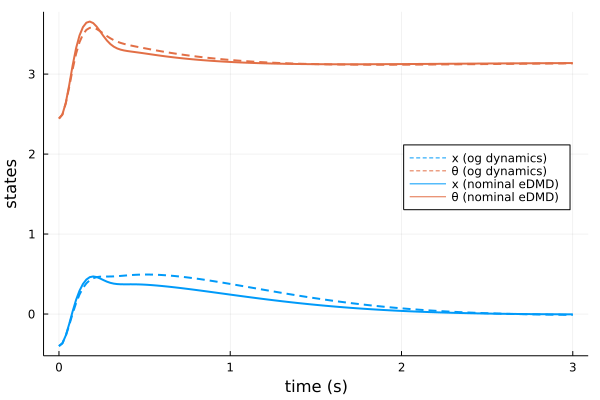

In [29]:
# Simulate nominal model with LQR gain from bilinear model

tf_sim = 3.0
Tsim_lqr_nominal = range(0,tf_sim,step=dt)

# x0 = [0,pi-deg2rad(1),0,0]
x0 = [-0.4,pi-deg2rad(40),0,0]

ctrl_lqr_og = LQRController(K_og, xe, ue)
ctrl_lqr_nominal = LQRController(K_bil_nom, xe, ue)

Xsim_lqr_og, = simulatewithcontroller(dmodel, ctrl_lqr_og, x0, tf_sim, dt)
Xsim_lqr_nominal, = simulatewithcontroller(dmodel, ctrl_lqr_nominal, x0, tf_sim, dt)

plotstates(Tsim_lqr_nominal, Xsim_lqr_og, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (og dynamics)" "θ (og dynamics)"], legend=:right, lw=2,
            linestyle=:dash, color=[1 2])
plotstates!(Tsim_lqr_nominal, Xsim_lqr_nominal, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (nominal eDMD)" "θ (nominal eDMD)"], legend=:right, lw=2,
            color=[1 2])

# Try Tracking Swing-up using TVLQR with Standard Model

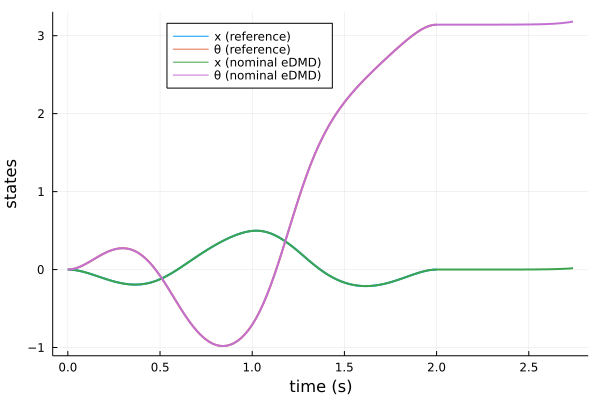

In [30]:
X_ref = vec(Matrix(map(x -> vec(x), X_test_swing_up[:,1]')))
U_ref = vec(Matrix(map(u -> vec(u), U_test_swing_up[:,1]')))

push!(X_ref, [0.0, pi, 0.0, 0.0])
push!(U_ref, [0.0])

num_knot = length(X_ref)
uN = length(U_ref)

A = [zeros(n,n) for k = 1:uN]
B = [zeros(n,m) for k = 1:uN]

for k in 1:uN
    A[k] = FiniteDiff.finite_difference_jacobian(x -> dynamics_bilinear(x, U_ref[k], 0.0, dt), X_ref[k])
    B[k] = FiniteDiff.finite_difference_jacobian(u -> dynamics_bilinear(X_ref[k], u, 0.0, dt), U_ref[k])
end

Qtvlqr = [Diagonal([1.0,5.0,1e-5,1e-5]) for k in 1:num_knot]
Rtvlqr = [Diagonal([1e-1]) for k in 1:num_knot]

tf_sim = 2.75
Tsim_tvlqr_nominal = range(0,tf_sim,step=dt)
x0 = X_ref[1]

tvlqr_ctrl = TVLQRController(A, B, Qtvlqr, Rtvlqr, X_ref, U_ref, T_ref)
Xsim_tvlqr_nominal, = simulatewithcontroller(dmodel, tvlqr_ctrl, x0, tf_sim, dt)

plotstates(T_ref, X_ref[1:end-1], inds=1:2, xlabel="time (s)", ylabel="states", label=["x (reference)" "θ (reference)"], legend=:top, lw=2)
plotstates!(Tsim_tvlqr_nominal, Xsim_tvlqr_nominal, inds=1:2, xlabel="time (s)", ylabel="states", label=["x (nominal eDMD)" "θ (nominal eDMD)"], legend=:top, lw=2)

# Evaluate New eDMD Model with Penalties on Jacobians
Here we incorporate derivative data by penalizing the difference of the Jacobian of the learned model from the expected Jacobians of the nominal model, e.g.:

$$ \sum_{j=1}^P || \frac{\partial}{\partial x} G \hat{f}(\varphi(x_j), u_j) - A_j ||^2 $$

where 

$$ \hat{f}(y,u) = A y + B u + \sum_{i=1}^m u_i C_i y $$

are the learned bilinear dynamics.

In [31]:
# Generate Jacobians
xn = zeros(n0)
jacobians = map(CartesianIndices(U_train)) do cind
    k = cind[1]
    x = X_train[cind]
    u = U_train[cind]
    z = RD.KnotPoint{n0,m}(x,u,T_ref[k],dt)
    J = zeros(n0,n0+m)
    RD.jacobian!(
        RD.InPlace(), RD.ForwardAD(), dmodel, J, xn, z 
    )
    J
end
A_train = map(J->J[:,1:n0], jacobians)
B_train = map(J->J[:,n0+1:end], jacobians)

# Convert states to lifted Koopman states
Y_train = map(kf, X_train)

# Calculate Jacobian of Koopman transform
F_train = map(@view X_train[1:end-1,:]) do x
    sparse(ForwardDiff.jacobian(x->expandstate(model_bilinear,x), x))
end;

### Build Least-squares problem
Find the eDMD data `A`, `B`, and `C` that minimize the following residual:

$$\sum_{j=1}^P (1-\alpha)|| A y_j + B u_j + \sum_{i=1}^m u_{j,i} C_i x_j - y_j^+ ||^2 + 
\alpha || G (A + \sum_{i=1}^m u_{j,i} C_j) F_j  - A_j ||^2 + 
\alpha || G (B + [C_1 x_j \dots C_m x_j]) - B_j ||^2  $$

where $F_j = \partial \varphi(x_j) / \partial x$.

This is equivalent to 

$$ (1-\alpha)|| E Z_{1:P} - Y_{1:P}^+ ||^2 + 
\alpha || G E \hat{A}_{1:P} - A_{1:P} ||^2 +
\alpha || G E \hat{B}_{1:P} - B_{1:P} ||^2 $$

where

$$ E = \begin{bmatrix} A & B & C_1 & \dots & C_m \end{bmatrix} \in \mathbb{R}^{n \times p} $$
$$ Z_j = \begin{bmatrix} 
    x_j \\ u_j \\ u_{j,1} x_j \\ \vdots \\ u_{j,m} x_j 
\end{bmatrix} \in \mathbb{R}^{p}, \quad
\hat{A}_j = \begin{bmatrix} 
    I_n \\ 0_{m,n} \\ u_{j,1} I_n \\ \vdots \\ u_{j,m} I_n 
\end{bmatrix} \in \mathbb{R}^{p \times n}, \quad
\hat{B}_j = \begin{bmatrix} 
    0_{n,m} \\ I_m \\ [x_j \; 0 \; \dots \; 0] \\ \vdots \\ [0 \; \dots \; 0 \; x_j] 
\end{bmatrix} \in \mathbb{R}^{p \times m}
$$

which is equivalent to 

$$ \left\lVert 
\begin{bmatrix} 
    Z_{1:P}^T \otimes I_n \\
    \hat{A}_{1:P}^T \otimes G \\
    \hat{B}_{1:P}^T \otimes G 
\end{bmatrix} \text{vec}(E) - 
\begin{bmatrix}
    \text{vec}{Y_{1:P}^+}\\
    \text{vec}{A_{1:P}^+}\\
    \text{vec}{B_{1:P}^+}\\
\end{bmatrix}
\right\rVert^2 $$

In [32]:
# Create a sparse version of the G Jacobian
G = spdiagm(n0,n,1=>ones(n0)) 
@test norm(G - model_bilinear.g) < 1e-8

# Build Least Squares Problem
W,s = BilinearControl.EDMD.build_edmd_data(
    Z_train, U_train, A_train, B_train, F_train, model_bilinear.g
);

Concatentating data
Creating feature matrix
Creating state Jacobian matrix
Creating control Jacobian matrix
Creating least-squares data


### Solve the Least-squares Problem

In [33]:
@time Wsparse = sparse(W)
@time F = qr(Wsparse)
@time x = F \ s
norm(W*x - s)

 10.524446 seconds (451.21 k allocations: 1.349 GiB, 4.96% gc time, 0.97% compilation time)
 43.590131 seconds (623 allocations: 25.191 GiB, 2.45% gc time, 0.02% compilation time)
  1.787458 seconds (33 allocations: 36.294 MiB, 0.62% gc time, 0.17% compilation time)


25624.90555044708

In [34]:
BilinearControl.matdensity(Wsparse)

0.1290566037735849

In [35]:
# Extract out bilinear dynamics
n = length(Z_train[1])
E = reshape(x,n,:)
A = E[:,1:n]
B = E[:,n .+ (1:m)]
C = E[:,n+m .+ (1:n*m)]

C_list = Matrix{Float64}[]
    
for i in 1:m
    C_i = C[:, (i-1)*n+1:i*n]
    push!(C_list, C_i)
end

return A, B, C_list, Matrix(g)

C = C_list;

In [36]:
# Save model
jldsave(joinpath(Problems.DATADIR,"cartpole_jacobian_penalized_eDMD_data.jld2"); A, B, C, g, kf, eigfuns, eigorders, tf, dt)

# Import New Model

In [37]:
cartpole_data = load(joinpath(Problems.DATADIR, "cartpole_jacobian_penalized_eDMD_data.jld2"))
A_jacpen = cartpole_data["A"]
B_jacpen = cartpole_data["B"]
C_jacpen = cartpole_data["C"]
g_jacpen = cartpole_data["g"]
kf = cartpole_data["kf"]
tf = cartpole_data["tf"]
dt = cartpole_data["dt"]

T_ref = range(0,tf,step=dt);

# Evaluate the New Fit

In [38]:
# Evaluate the Fit
err_train2 = BilinearControl.EDMD.fiterror(A_jacpen, B_jacpen, C_jacpen, g_jacpen, kf, X_train, U_train)
err_test_swing_up2 = BilinearControl.EDMD.fiterror(A_jacpen, B_jacpen, C_jacpen, g_jacpen, kf, X_test_swing_up, U_test_swing_up)
err_test_stabilize2 = BilinearControl.EDMD.fiterror(A_jacpen, B_jacpen, C_jacpen, g_jacpen, kf, X_test_stabilize, U_test_stabilize)

println("Train Error: ", err_train)
println("Swing-up Test Error:  ", err_test_swing_up)
println("Stabilization Test Error:  ", err_test_stabilize)
println("")
println("New Train Error: ", err_train2)
println("New Swing-up Test Error:  ", err_test_swing_up2)
println("New Stabilization Test Error:  ", err_test_stabilize2)

Train Error: 0.00970062565994878
Swing-up Test Error:  0.05276273389163401
Stabilization Test Error:  0.7188724443629827

New Train Error: 0.022155162175419713
New Swing-up Test Error:  0.07598823864638633
New Stabilization Test Error:  0.052887591500971755


In [39]:
model_bilinear_jacpen = EDMDModel(A_jacpen, B_jacpen, C_jacpen, g_jacpen, kf, dt, "cartpole")
n,m = RD.dims(model_bilinear_jacpen)
n0 = originalstatedim(model_bilinear_jacpen)

# create cartpole model
model = Cartpole2()
dmodel = RD.DiscretizedDynamics{RD.RK4}(model);

# Define the equilibrium
xe = [0.0,pi,0.0,0.0]
ue = [0.0]
ze = RD.KnotPoint{n0,m}(xe,ue,0.0,dt)

# Nominal Jacobians
J = zeros(n0,n0+m)
xn = zeros(n0)
RD.jacobian!(RD.InPlace(), RD.ForwardAD(), dmodel, J, xn, ze)
A_og = J[:,1:n0]
B_og = J[:,n0+1:end];

In [40]:
# Get A,B for new system
function dynamics_bilinear_jacpen(x,u,t,dt)
    y = expandstate(model_bilinear_jacpen, x)
    yn = zero(y)
    RD.discrete_dynamics!(model_bilinear_jacpen, yn, y, u, t, dt)
    originalstate(model_bilinear_jacpen, yn)
end

A_bil_jacpen = FiniteDiff.finite_difference_jacobian(x->dynamics_bilinear_jacpen(x,ue,0.0,dt), xe)
B_bil_jacpen = FiniteDiff.finite_difference_jacobian(u->dynamics_bilinear_jacpen(xe,u,0.0,dt), ue);

**Compare the Jacobians with Nominal model**

In [41]:
A_og

4×4 Matrix{Float64}:
 1.0  0.000392055   0.019998     -1.38375e-6
 0.0  1.0047       -3.99648e-6    0.0199834
 0.0  0.0392035     0.9998       -7.57316e-6
 0.0  0.470481     -0.000399628   0.999909

In [42]:
A_bil_jacpen

4×4 Matrix{Float64}:
  1.0          0.00037327   0.0200043   -2.58873e-6
 -8.61287e-6   1.00465     -1.49012e-5   0.0199863
  0.000469506  0.0375339    1.00048     -0.00014497
 -0.000940204  0.465304    -0.00141549   1.00019

In [43]:
B_og

4×1 Matrix{Float64}:
 0.00019995956333333334
 0.00039964806000000004
 0.01999523290316667
 0.03996279079433334

In [44]:
B_bil_jacpen

4×1 Matrix{Float64}:
 0.00019778976326279007
 0.0003978610038757324
 0.019819391252895002
 0.03987927798880264

# Try Stabilizing New Model using LQR

In [45]:
Qlqr = Diagonal([1.0,10.0,1e-2,1e-2])
Rlqr = Diagonal([1e-4])
K_og = dlqr(A_og, B_og, Qlqr, Rlqr)
K_bil_jacpen = dlqr(A_bil_jacpen, B_bil_jacpen, Qlqr, Rlqr);

In [46]:
# Evaluate stability
isstable_nominal = maximum(abs.(eigvals(A_og - B_og*K_og))) < 1.0
isstable_bilinear2 = maximum(abs.(eigvals(A_bil_jacpen - B_bil_jacpen*K_bil_jacpen))) < 1.0
isstable_nominal_with_bilinear2 = maximum(abs.(eigvals(A_og - B_og*K_bil_jacpen))) < 1.0

println("Stability Summary:")
println("  Dynamics  |  Controller  |  is stable? ")
println("------------|--------------|--------------")
println("  Nominal   |  Nominal     |  ", isstable_nominal)
println("  Bilinear  |  Bilinear    |  ", isstable_bilinear2)
println("  Nominal   |  Bilinear    |  ", isstable_nominal_with_bilinear2)

Stability Summary:
  Dynamics  |  Controller  |  is stable? 
------------|--------------|--------------
  Nominal   |  Nominal     |  true
  Bilinear  |  Bilinear    |  true
  Nominal   |  Bilinear    |  true


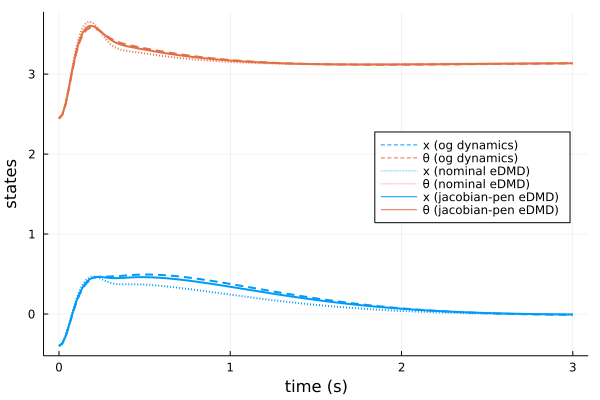

In [47]:
tf_sim = 3.0
Tsim_lqr_jacpen = range(0,tf_sim,step=dt)

x0 = [-0.4,pi-deg2rad(40),0,0]

ctrl_lqr_jacpen = LQRController(K_bil_jacpen, xe, ue)
Xsim_lqr_jacpen, = simulatewithcontroller(dmodel, ctrl_lqr_jacpen, x0, tf_sim, dt)

plotstates(Tsim_lqr_nominal, Xsim_lqr_og, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (og dynamics)" "θ (og dynamics)"], legend=:right, lw=2,
            linestyle=:dash, color=[1 2])
plotstates!(Tsim_lqr_nominal, Xsim_lqr_nominal, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (nominal eDMD)" "θ (nominal eDMD)"], legend=:right, lw=2,
            linestyle=:dot, color=[1 2])
plotstates!(Tsim_lqr_jacpen, Xsim_lqr_jacpen, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (jacobian-pen eDMD)" "θ (jacobian-pen eDMD)"], legend=:right, lw=2,
            color=[1 2])

In [48]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [49]:
visualize!(vis, model, tf_sim, Xsim_lqr_jacpen)

# Try Tracking Swing-up using TVLQR with New Model

In [50]:
# # Extract Reference Trajectory
# X_ref = vec(Matrix(map(x -> vec(x), X_test[:,1]')))
# U_ref = vec(Matrix(map(u -> vec(u), U_test[:,1]')))

# # Linearize in Koopman Space
# Z_ref = map(x -> expandstate(model_bilinear2, x), X_ref)
# A, B = linearize(model_bilinear2, Z_ref, U_ref, T_ref)

# # TVLQRController
# Qtvlqr = [Diagonal(1e-2*ones(n)) for knot in 1:num_knot]
# Rtvlqr = [Diagonal([1e-4]) for knot in 1:num_knot]

# # Simulate with controller
# ctrl_tvlqr = TVLQRController(A,B,Qtvlqr,Rtvlqr, Z_ref, U_ref, T_ref)
# t_sim = 3
# Tsim_tvlqr_jacpen = range(0,t_sim,step=dt)
# z0 = Z_ref[1]
# Zsim_tvlqr, = simulatewithcontroller(model_bilinear2, ctrl_tvlqr, z0, t_sim, dt)
# Xsim_tvlqr_koopman = map(z -> originalstate(model_bilinear2, z), Zsim_tvlqr)
# plotstates(T_ref, X_ref, inds=1:2, xlabel="time (s)", ylabel="states", label=["x (reference)" "θ (reference)"], legend=:top, lw=2)
# plotstates!(Tsim_tvlqr_jacpen, Xsim_tvlqr_koopman, inds=1:2, xlabel="time (s)", ylabel="states", label=["x (TVLQR)" "θ (TVLQR)"], legend=:top, lw=2)

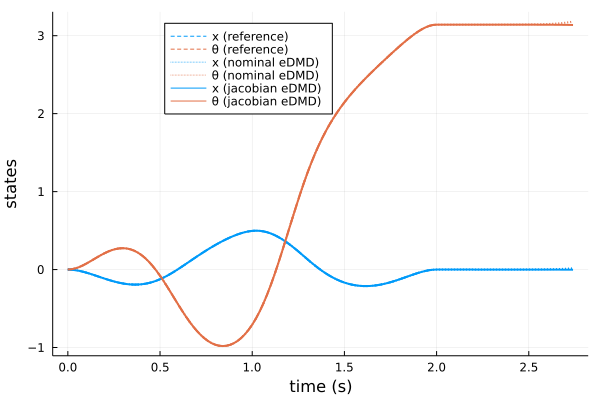

In [51]:
X_ref = vec(Matrix(map(x -> vec(x), X_test_swing_up[:,1]')))
U_ref = vec(Matrix(map(u -> vec(u), U_test_swing_up[:,1]')))

push!(X_ref, [0.0, pi, 0.0, 0.0])
push!(U_ref, [0.0])

num_knot = length(X_ref)
uN = length(U_ref)

A = [zeros(n,n) for k = 1:uN]
B = [zeros(n,m) for k = 1:uN]

for k in 1:uN
    A[k] = FiniteDiff.finite_difference_jacobian(x -> dynamics_bilinear_jacpen(x, U_ref[k], 0.0, dt), X_ref[k])
    B[k] = FiniteDiff.finite_difference_jacobian(u -> dynamics_bilinear_jacpen(X_ref[k], u, 0.0, dt), U_ref[k])
end

Qtvlqr = [Diagonal([1.0,5.0,1e-5,1e-5]) for k in 1:num_knot]
Rtvlqr = [Diagonal([1e-1]) for k in 1:num_knot]

tf_sim = 2.75
Tsim_tvlqr_jacpen = range(0,tf_sim,step=dt)
x0 = X_ref[1]

tvlqr_ctrl = TVLQRController(A, B, Qtvlqr, Rtvlqr, X_ref, U_ref, T_ref)
Xsim_tvlqr_jacpen, = simulatewithcontroller(dmodel, tvlqr_ctrl, x0, tf_sim, dt)

plotstates(T_ref, X_ref[1:end-1], inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (reference)" "θ (reference)"], legend=:top, lw=2,
            linestyle=:dash, color=[1 2])
plotstates!(Tsim_tvlqr_nominal, Xsim_tvlqr_nominal, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (nominal eDMD)" "θ (nominal eDMD)"], legend=:top, lw=2,
            linestyle=:dot, color=[1 2])
plotstates!(Tsim_tvlqr_jacpen, Xsim_tvlqr_jacpen, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (jacobian eDMD)" "θ (jacobian eDMD)"], legend=:top, lw=2,
            color=[1 2])

In [52]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [53]:
visualize!(vis, model, tf_sim, Xsim_tvlqr_jacpen)